# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
  ⋮
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0
 -1.0
 -1.0

### We create a function to visualize the data

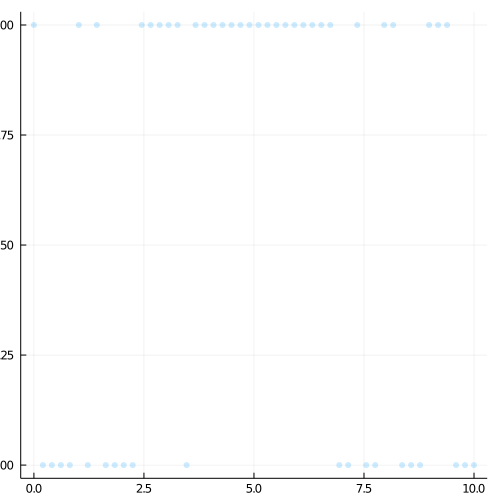

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.735597 seconds (1.15 M allocations: 67.485 MiB, 99.40% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:07
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:06
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:04
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:33
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:14
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:01
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:52
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.44780570834642136, -0.646764654191191, -0.908220927099161, -1.1333668416561329, -1.3277486506627565, -1.4962416078898828, -1.5427190948557494, -1.4461722717661984, -1.2471864491537574, -0.8666012837579086  …  0.48934587597856033, 0.4366747327361875, 0.3169476312217847, 0.17056390448301711, -0.024495568856188005, -0.15127192310901183, -0.25168892092494183, -0.2696017991432114, -0.1523082046735144, -0.020870501545168507]]
 [[-0.8969359649968512, -1.1281136765518762, -1.314430346254267, -1.3931206198273896, -1.345580015857501, -1.2052060690705175, -1.0059545065806186, -0.8226968234776764, -0.6441790890424932, -0.5271396655607886  …  0.5645896944551099, 0.5315979423803959, 0.47976314675752324, 0.4432118462598882, 0.3853170965565682, 0.302648428367119, 0.19821981205935665, 0.04726500988408122, -0.14220133824216605, -0.39086614168627865]]
 [[-0.2618497052143417, -0.1077277131946226, -0.011918646595350357, -0.009571887254489986, -0.056628593

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

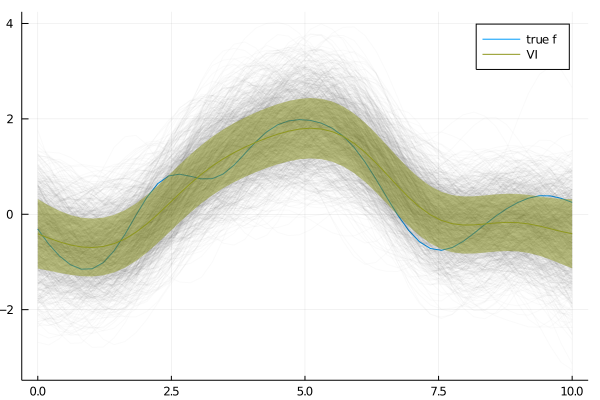

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

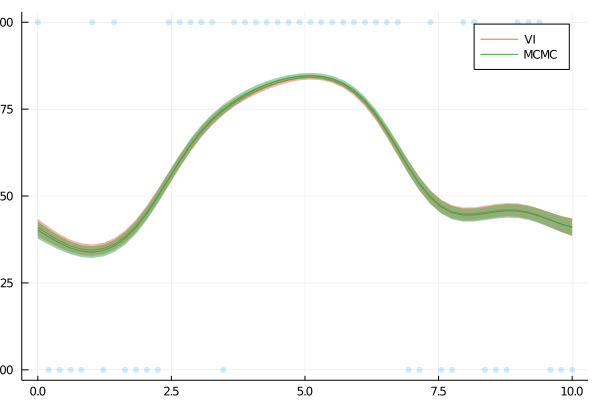

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*